Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Cosmology: {'omega_cold': 0.3615725282545138, 'omega_baryon': 0.04877756879504105, 'hubble': 0.7717195839822766, 'sigma8_cold': 0.8485525649400919, 'ns': 0.9284759613098885, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'omega_m': 0.3615725282545138}


/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1.

Saved plot to plots/pk_bacco.pdf


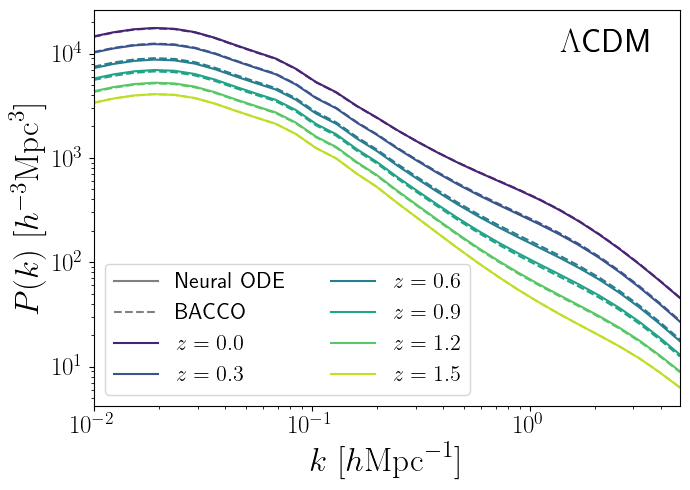

In [6]:
# inference_and_plot.py

import os
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import baccoemu

# --- BACCO emulator setup ---
bacco = baccoemu.Matter_powerspectrum()
k_full = np.logspace(-2, np.log10(bacco.emulator["nonlinear"]["k"].max()), 30)
k = k_full
k_shp = len(k)

# --- Random cosmology ---
rng = np.random.default_rng(seed=42)
params = {
    'omega_cold': rng.uniform(0.23, 0.4),
    'omega_baryon': rng.uniform(0.04, 0.06),
    'hubble': rng.uniform(0.6, 0.8),
    'sigma8_cold': rng.uniform(0.73, 0.9),
    'ns': rng.uniform(0.92, 1.01),
    'neutrino_mass': 0.0,
    'w0': -1.0,
    'wa': 0.0
}
params['omega_m'] = params['omega_cold'] 

print("Cosmology:", params)

# --- Compute P(k,z) from BACCO ---
def get_nonlinear_pk(z):
    params["expfactor"] = 1.0 / (1.0 + z)
    _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
    return pk

def get_bacco_logpk(z):
    return jnp.log(get_nonlinear_pk(z))

# --- Background ---
G = 4.30091e-9
def Hz_func(z):
    Om = params['omega_m']
    h = params['hubble']
    return 100. * h * jnp.sqrt(Om * (1 + z) ** 3 + (1 - Om))

def rho_m_func(z):
    Om = params['omega_m']
    h = params['hubble']
    rho_crit_0 = 3 * (100. * h) ** 2 / (8 * jnp.pi * G)
    return Om * rho_crit_0 * (1 + z) ** 3

# --- Load normalization data ---
norm = np.load("/srv/scratch3/taylor.4264/odd_emu/production_run_bacco/merged/logpk_data.npz")
Hz_all = norm["Hz"]
rho_m_all = norm["rho_m"]
H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_all = np.log10(rho_m_all + 1e-30)
rho_mean, rho_std = log_rho_all.mean(), log_rho_all.std()

def H_norm(z):
    return (Hz_func(z) - H_mean) / H_std

def rho_norm(z):
    return (jnp.log10(rho_m_func(z) + 1e-30) - rho_mean) / rho_std

# --- Initial condition ---
z0, z1 = 1.5, 0.0
ts = jnp.linspace(z0, z1, 20)
logpk0 = jnp.log(get_nonlinear_pk(z0).astype(jnp.float32))

# --- Define model ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)
    
    def __call__(self, P, H, rho, z):
        H = jnp.atleast_1d(H)
        rho = jnp.atleast_1d(rho)
        z = jnp.atleast_1d(z)
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Solve with multiple models ---
model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final_bacco"
all_pk = []

def rhs(z, logP, args):
    model, = args
    return model(logP, H_norm(z), rho_norm(z), z)

for i in range(10):
    path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(path, model)
    model = eqx.combine(model_params, model)

    sol = diffeqsolve(
        ODETerm(rhs),
        Tsit5(),
        t0=z0,
        t1=z1,
        dt0=-1e-2,
        y0=logpk0,
        args=(model,),
        saveat=SaveAt(ts=ts)
    )
    all_pk.append(jnp.exp(sol.ys))

pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

# --- Plot ---
z_list = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(z_list)))
plt.figure(figsize=(7, 5))

for i, z in enumerate(z_list):
    z_idx = int(jnp.argmin(jnp.abs(ts - z)))
    pk_pred = pk_mean[z_idx]
    pk_true = get_nonlinear_pk(z)

    plt.plot(k, pk_pred, color=colors[i], ls='-')
    plt.plot(k, pk_true, color=colors[i], ls='--')

# Axes settings
import matplotlib as mpl
from matplotlib import rcParams

plt.rc('text', usetex=True)


# Set global font sizes
rcParams.update({
    "legend.fontsize": 18,         # Legend text
    "axes.labelsize": 24,          # Axis labels
    "xtick.labelsize": 18,         # X-axis tick labels
    "ytick.labelsize": 18          # Y-axis tick labels
})

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k\ [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k)\ [ h^{-3} \mathrm{Mpc}^3]$")
plt.xlim(k.min(), k.max())

# Legend
style_handles = [
    Line2D([0], [0], color='gray', ls='-', label='Neural ODE'),
    Line2D([0], [0], color='gray', ls='--', label='BACCO')
]
color_handles = [
    Line2D([0], [0], color=colors[i], ls='-', label=fr'$z={z}$')
    for i, z in enumerate(z_list)
]
plt.legend(handles = style_handles + color_handles, fontsize=16, ncol=2, loc='lower left')
plt.tight_layout()
plt.text(0.95, 0.95, r"$\Lambda$CDM", ha='right', va='top', transform=plt.gca().transAxes, fontsize=24)
plt.savefig("plots/pk.pdf")
print("Saved plot to plots/pk_bacco.pdf")

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1.

Cosmology: {'omega_cold': 0.3615725282545138, 'omega_baryon': 0.04877756879504105, 'hubble': 0.7717195839822766, 'sigma8_cold': 0.8485525649400919, 'ns': 0.9284759613098885, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'omega_m': 0.3615725282545138}
Cosmology: {'omega_cold': 0.3408908746591548, 'omega_baryon': 0.04087550647277993, 'hubble': 0.6040059173748433, 'sigma8_cold': 0.8726661390268751, 'ns': 0.9728428742829253, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'omega_m': 0.3408908746591548}
Cosmology: {'omega_cold': 0.25083613664455817, 'omega_baryon': 0.045162261495455464, 'hubble': 0.6811541455642263, 'sigma8_cold': 0.8947612711845517, 'ns': 0.934608541230701, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'omega_m': 0.25083613664455817}
Cosmology: {'omega_cold': 0.32743221168107595, 'omega_baryon': 0.05056982290340405, 'hubble': 0.7527300479603852, 'sigma8_cold': 0.8679877703916332, 'ns': 0.9659205969680652, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'omega_m': 0.327432211681075

Text(0.95, 0.95, '$\\Lambda$CDM')

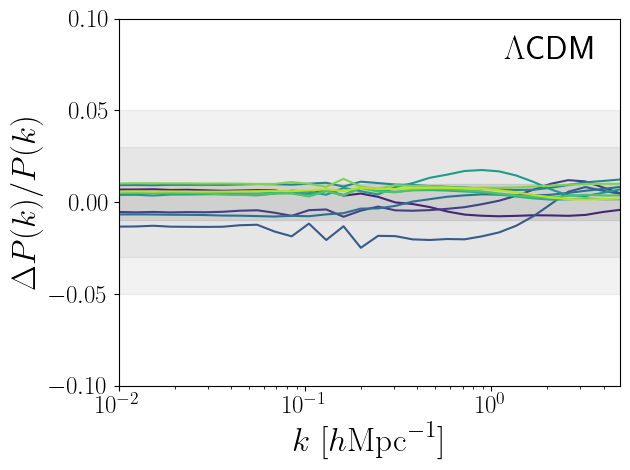

In [23]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
from matplotlib import pyplot as plt
import os

plt.rc('text', usetex=True)
plt.rcParams.update({
    "legend.fontsize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

# --- Load emulator and k ---
bacco = baccoemu.Matter_powerspectrum()
k_full = np.logspace(-2, np.log10(bacco.emulator["nonlinear"]["k"].max()), 30)
k = k_full
k_shp = len(k)


# --- Load normalization data ---
data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
norm_data = np.load(os.path.join(data_dir, "logpk_data_with_dHz_dz.npz"))
Hz_all = norm_data["Hz"]
rho_m_all = norm_data["rho_m"]
dHz_dz_all = norm_data["dHz_dz"]

H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_mean, log_rho_std = np.log10(rho_m_all + 1e-30).mean(), np.log10(rho_m_all + 1e-30).std()
dH_mean, dH_std = dHz_dz_all.mean(), dHz_dz_all.std()

# --- Constants ---
G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

# --- Model RHS function ---
colors = plt.cm.viridis(np.linspace(0.1, 0.9, 10))

residual_lcdm = []
for j in range(10):
    # --- Random cosmology ---
    rng = np.random.default_rng(seed=42 +j )
    params = {
        'omega_cold': rng.uniform(0.23, 0.4),
        'omega_baryon': rng.uniform(0.04, 0.06),
        'hubble': rng.uniform(0.6, 0.8),
        'sigma8_cold': rng.uniform(0.73, 0.9),
        'ns': rng.uniform(0.92, 1.01),
        'neutrino_mass': 0.0,
        'w0': -1.0,
        'wa': 0.0
    }
    params['omega_m'] = params['omega_cold'] 

    print("Cosmology:", params)

    # --- Compute P(k,z) from BACCO ---
    def get_nonlinear_pk(z):
        params["expfactor"] = 1.0 / (1.0 + z)
        _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
        return pk

    # --- Background ---
    G = 4.30091e-9
    def Hz_func(z):
        Om = params['omega_m']
        h = params['hubble']
        return 100. * h * jnp.sqrt(Om * (1 + z) ** 3 + (1 - Om))

    def rho_m_func(z):
        Om = params['omega_m']
        h = params['hubble']
        rho_crit_0 = 3 * (100. * h) ** 2 / (8 * jnp.pi * G)
        return Om * rho_crit_0 * (1 + z) ** 3

    # --- Load normalization data ---
    norm = np.load("/srv/scratch3/taylor.4264/odd_emu/production_run_bacco/merged/logpk_data.npz")
    Hz_all = norm["Hz"]
    rho_m_all = norm["rho_m"]
    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    rho_mean, rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - rho_mean) / rho_std

    # --- Initial condition ---
    z0, z1 = 1.5, 0.0
    ts = jnp.linspace(z0, z1, 20)
    logpk0 = jnp.log(get_nonlinear_pk(z0).astype(jnp.float32))

    # --- Define model ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)
        
        def __call__(self, P, H, rho, z):
            H = jnp.atleast_1d(H)
            rho = jnp.atleast_1d(rho)
            z = jnp.atleast_1d(z)
            x = jnp.concatenate([P, H, rho, z])
            return self.mlp(x)

    # --- Solve with multiple models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final_bacco"
    all_pk = []

    def rhs(z, logP, args):
        model, = args
        return model(logP, H_norm(z), rho_norm(z), z)

    for i in range(10):
        path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(path, model)
        model = eqx.combine(model_params, model)

        sol = diffeqsolve(
            ODETerm(rhs),
            Tsit5(),
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=SaveAt(ts=ts)
        )
        all_pk.append(jnp.exp(sol.ys))

    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)
    pk_z0_ode = pk_mean[-1]
    pk_z0_bacco = jnp.exp(get_bacco_logpk(0.0))
    residual = (pk_z0_ode - pk_z0_bacco) / pk_z0_bacco
    residual_lcdm += [residual]

    plt.plot(k, residual, color=colors[j])

plt.axhspan(-0.01, 0.01, color='gray', alpha=0.2)
plt.axhspan(-0.03, 0.03, color='gray', alpha=0.1)
plt.axhspan(-0.05, 0.05, color='gray', alpha=0.1)
plt.xscale("log")
plt.xlabel(r"$k\ [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\Delta P(k)/P(k)$")
plt.ylim(-0.1, 0.1)
plt.tight_layout()
plt.xlim(k.min(), k.max())
plt.text(0.95, 0.95, r"$\Lambda$CDM", ha='right', va='top', transform=plt.gca().transAxes, fontsize=24)
#plt.savefig("plots/error.pdf")

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Cosmology: {'omega_cold': 0.3615725282545138, 'omega_baryon': 0.04877756879504105, 'hubble': 0.7717195839822766, 'sigma8_cold': 0.8485525649400919, 'ns': 0.9284759613098885, 'neutrino_mass': 0.0, 'w0': -0.8573132945089732, 'wa': 0.15668382119421176, 'omega_m': 0.3615725282545138}


/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1.

Cosmology: {'omega_cold': 0.3408908746591548, 'omega_baryon': 0.04087550647277993, 'hubble': 0.6040059173748433, 'sigma8_cold': 0.8726661390268751, 'ns': 0.9728428742829253, 'neutrino_mass': 0.0, 'w0': -1.0825884309389127, 'wa': 0.1510753630911693, 'omega_m': 0.3408908746591548}
Cosmology: {'omega_cold': 0.25083613664455817, 'omega_baryon': 0.045162261495455464, 'hubble': 0.6811541455642263, 'sigma8_cold': 0.8947612711845517, 'ns': 0.934608541230701, 'neutrino_mass': 0.0, 'w0': -0.8928118979329684, 'wa': -0.2021728373573607, 'omega_m': 0.25083613664455817}
Cosmology: {'omega_cold': 0.32743221168107595, 'omega_baryon': 0.05056982290340405, 'hubble': 0.7527300479603852, 'sigma8_cold': 0.8679877703916332, 'ns': 0.9659205969680652, 'neutrino_mass': 0.0, 'w0': -0.9161980982806637, 'wa': 0.1776679826760268, 'omega_m': 0.32743221168107595}
Cosmology: {'omega_cold': 0.38395272703735306, 'omega_baryon': 0.041544535864234865, 'hubble': 0.6545139511837276, 'sigma8_cold': 0.8357145819818426, 'ns':

Text(0.95, 0.95, '$w_0$$w_a$CDM')

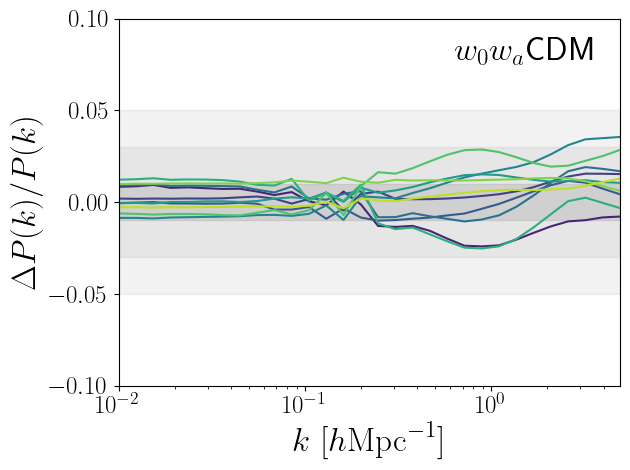

In [24]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
from matplotlib import pyplot as plt
import os

plt.rc('text', usetex=True)
plt.rcParams.update({
    "legend.fontsize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

# --- Load emulator and k ---
bacco = baccoemu.Matter_powerspectrum()
k_full = np.logspace(-2, np.log10(bacco.emulator["nonlinear"]["k"].max()), 30)
k = k_full
k_shp = len(k)


# --- Load normalization data ---
data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
norm_data = np.load(os.path.join(data_dir, "logpk_data_with_dHz_dz.npz"))
Hz_all = norm_data["Hz"]
rho_m_all = norm_data["rho_m"]
dHz_dz_all = norm_data["dHz_dz"]

H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_mean, log_rho_std = np.log10(rho_m_all + 1e-30).mean(), np.log10(rho_m_all + 1e-30).std()
dH_mean, dH_std = dHz_dz_all.mean(), dHz_dz_all.std()

# --- Constants ---
G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

# --- Model RHS function ---
colors = plt.cm.viridis(np.linspace(0.1, 0.9, 10))

residual_wz = []
for j in range(10):
    # --- Random cosmology ---
    rng = np.random.default_rng(seed=42 +j )
    params = {
        'omega_cold': rng.uniform(0.23, 0.4),
        'omega_baryon': rng.uniform(0.04, 0.06),
        'hubble': rng.uniform(0.6, 0.8),
        'sigma8_cold': rng.uniform(0.73, 0.9),
        'ns': rng.uniform(0.92, 1.01),
        'neutrino_mass': 0.0,
        'w0': rng.uniform(-1.15,-0.85),
        'wa': rng.uniform(-0.3,0.3)
    }
    params['omega_m'] = params['omega_cold'] 

    print("Cosmology:", params)

    # --- Compute P(k,z) from BACCO ---
    def get_nonlinear_pk(z):
        params["expfactor"] = 1.0 / (1.0 + z)
        _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
        return pk

    # --- Background ---
    G = 4.30091e-9

    '''
    def Hz_func(z):
        Om = params['omega_m']
        h = params['hubble']
        return 100. * h * jnp.sqrt(Om * (1 + z) ** 3 + (1 - Om))
    '''

    
    def Hz_func(z):
        Om = params['omega_m']
        h = params['hubble']
        w0 = params['w0']
        wa = params['wa']
        
        a = 1.0 / (1.0 + z)
        de_factor = a**(-3 * (1 + w0 + wa)) * jnp.exp(-3 * wa * z / (1 + z))
        
        return 100.0 * h * jnp.sqrt(Om * (1 + z)**3 + (1 - Om) * de_factor)
    

    def rho_m_func(z):
        Om = params['omega_m']
        h = params['hubble']
        rho_crit_0 = 3 * (100. * h) ** 2 / (8 * jnp.pi * G)
        return Om * rho_crit_0 * (1 + z) ** 3

    # --- Load normalization data ---
    norm = np.load("/srv/scratch3/taylor.4264/odd_emu/production_run_bacco/merged/logpk_data.npz")
    Hz_all = norm["Hz"]
    rho_m_all = norm["rho_m"]
    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    rho_mean, rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - rho_mean) / rho_std

    # --- Initial condition ---
    z0, z1 = 1.5, 0.0
    ts = jnp.linspace(z0, z1, 20)
    logpk0 = jnp.log(get_nonlinear_pk(z0).astype(jnp.float32))

    # --- Define model ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)
        
        def __call__(self, P, H, rho, z):
            H = jnp.atleast_1d(H)
            rho = jnp.atleast_1d(rho)
            z = jnp.atleast_1d(z)
            x = jnp.concatenate([P, H, rho, z])
            return self.mlp(x)

    # --- Solve with multiple models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final_bacco"
    all_pk = []

    def rhs(z, logP, args):
        model, = args
        return model(logP, H_norm(z), rho_norm(z), z)

    for i in range(10):
        path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(path, model)
        model = eqx.combine(model_params, model)

        sol = diffeqsolve(
            ODETerm(rhs),
            Tsit5(),
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=SaveAt(ts=ts)
        )
        all_pk.append(jnp.exp(sol.ys))

    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)
    pk_z0_ode = pk_mean[-1]
    pk_z0_bacco = jnp.exp(get_bacco_logpk(0.0))
    residual = (pk_z0_ode - pk_z0_bacco) / pk_z0_bacco
    residual_wz += [residual]
    

    plt.plot(k, residual, color=colors[j])

plt.axhspan(-0.01, 0.01, color='gray', alpha=0.2)
plt.axhspan(-0.03, 0.03, color='gray', alpha=0.1)
plt.axhspan(-0.05, 0.05, color='gray', alpha=0.1)
plt.xscale("log")
plt.xlabel(r"$k\ [h\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\Delta P(k)/P(k)$")
plt.ylim(-0.1, 0.1)
plt.tight_layout()
plt.xlim(k.min(), k.max())
plt.text(0.95, 0.95, r"$w_0$$w_a$CDM", ha='right', va='top', transform=plt.gca().transAxes, fontsize=24)
#plt.savefig("plots/error_DE.pdf")

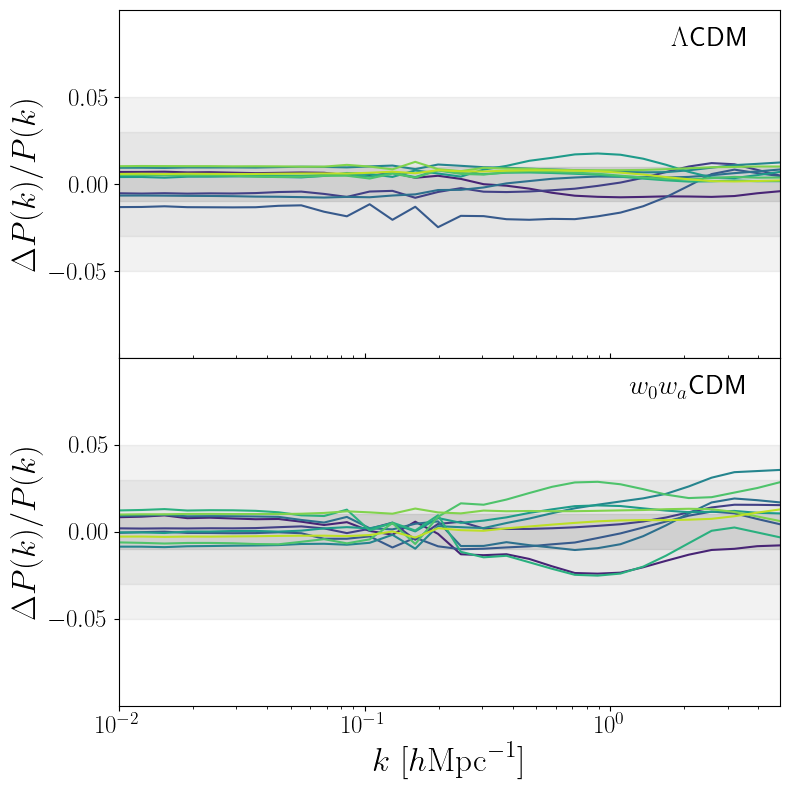

In [36]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 8), 
    sharex=True,
    gridspec_kw={'hspace': 0}  # No vertical space between plots
)

# --- Plot 1: ΛCDM residuals on ax1 ---
for j in range(10):
    ax1.plot(k, residual_lcdm[j], color=colors[j])  # Assuming you've stored them in a list
ax1.axhspan(-0.01, 0.01, color='gray', alpha=0.2)
ax1.axhspan(-0.03, 0.03, color='gray', alpha=0.1)
ax1.axhspan(-0.05, 0.05, color='gray', alpha=0.1)
ax1.set_yscale("linear")
ax1.set_ylabel(r"$\Delta P(k)/P(k)$")
ax1.set_ylim(-0.1, 0.1)
ax1.text(0.95, 0.95, r"$\Lambda$CDM", ha='right', va='top', transform=ax1.transAxes, fontsize=20)


# --- Plot 2: w₀–wₐCDM residuals on ax2 ---
for j in range(10):
    ax2.plot(k, residual_wz[j], color=colors[j])  # Again assuming stored per run
ax2.axhspan(-0.01, 0.01, color='gray', alpha=0.2)
ax2.axhspan(-0.03, 0.03, color='gray', alpha=0.1)
ax2.axhspan(-0.05, 0.05, color='gray', alpha=0.1)
ax2.set_xscale("log")
ax2.set_xlabel(r"$k\ [h\mathrm{Mpc}^{-1}]$")
ax2.set_ylabel(r"$\Delta P(k)/P(k)$")
ax2.set_ylim(-0.1, 0.1)
ax2.text(0.95, 0.95, r"$w_0$$w_a$CDM", ha='right', va='top', transform=ax2.transAxes, fontsize=20)

# Get tick positions
yticks1 = ax1.get_yticks()
yticks2 = ax2.get_yticks()

# Remove bottom tick from top axes to avoid overlap
yticks1 = yticks1[1:-1]
yticks2 = yticks2[1:4]

# Set manually
ax1.set_yticks(yticks1)
ax2.set_yticks(yticks2)

# Optional: Set labels manually for consistency
ax1.set_yticklabels([rf"${y:.2f}$" for y in yticks1])
ax2.set_yticklabels([rf"${y:.2f}$" for y in yticks2])

# Enable top x-ticks on bottom plot
ax2.tick_params(axis='x', which='both', top=True, labeltop=False)

# Optional: hide bottom x-tick labels on top plot if visible
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# --- Final layout ---
plt.xlim(k.min(), k.max())
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)  # Extra control over spacing if needed
plt.savefig("plots/error_comparison.pdf")

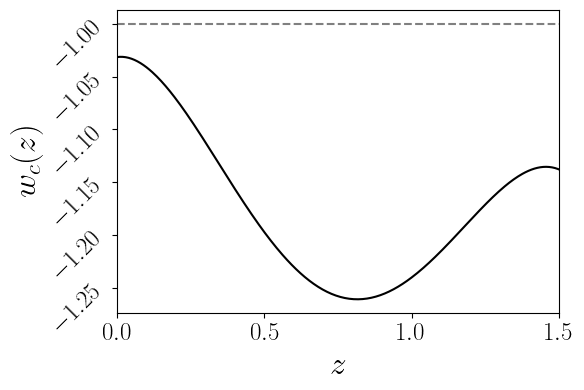

In [9]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np  # Still needed for fitting coefficients

# Given w(z) data points
x1 = np.array([0., 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5])
y1 = np.array([-0.97, -1.2, -1.1, -1.05, -1.2, -1.3, -1.4, -1.15, -1.15, -1.15, -1.15])

# Fit degree-4 polynomial (still done with NumPy)
coeffs = np.polyfit(x1, y1, deg=4)
w_coeffs = jnp.array(coeffs)

# Plotting
z_plot = jnp.linspace(0, 1.5, 300)
w_plot = jnp.polyval(w_coeffs, z_plot)

plt.figure(figsize=(6, 4))
plt.plot(z_plot, w_plot, label=r"$w(z)$", color='k')
plt.axhline(y=-1, color='gray', ls='--', label=r"$w=-1$")

plt.xlim(0, 1.5)
plt.xlabel(r"$z$")
plt.ylabel(r"$w_c(z)$")
plt.tick_params(axis='y', labelrotation=45)

plt.tight_layout()
plt.savefig('plots/w_p.pdf')

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Cosmology: {'omega_cold': 0.3615725282545138, 'omega_baryon': 0.04877756879504105, 'hubble': 0.7717195839822766, 'sigma8_cold': 0.8485525649400919, 'ns': 0.9284759613098885, 'neutrino_mass': 0.0, 'w0': -1.15, 'wa': 0.0, 'omega_m': 0.3615725282545138}


/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/scratch1/taylor.4264/anaconda3/envs/odd_emu/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1.

Saved plot to plots/pk_wz.pdf


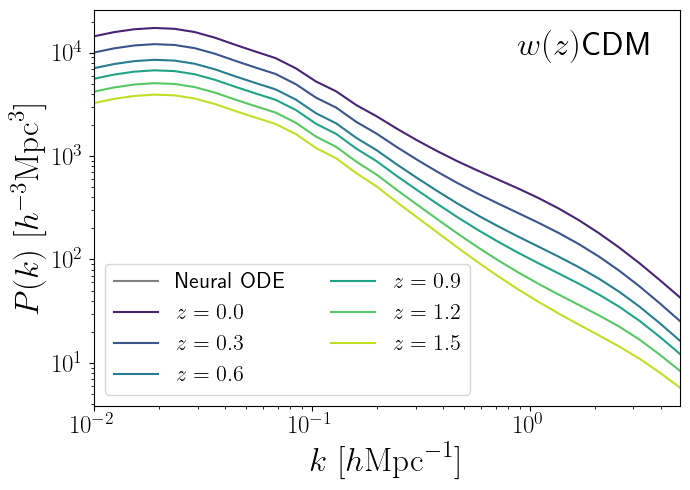

In [11]:
# inference_and_plot.py

import os
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import baccoemu

# --- BACCO emulator setup ---
bacco = baccoemu.Matter_powerspectrum()
k_full = np.logspace(-2, np.log10(bacco.emulator["nonlinear"]["k"].max()), 30)
k = k_full
k_shp = len(k)

# --- Random cosmology ---
rng = np.random.default_rng(seed=42)
params = {
    'omega_cold': rng.uniform(0.23, 0.4),
    'omega_baryon': rng.uniform(0.04, 0.06),
    'hubble': rng.uniform(0.6, 0.8),
    'sigma8_cold': rng.uniform(0.73, 0.9),
    'ns': rng.uniform(0.92, 1.01),
    'neutrino_mass': 0.0,
    'w0': -1.15,
    'wa': 0.0
}
params['omega_m'] = params['omega_cold'] 

print("Cosmology:", params)

# --- Compute P(k,z) from BACCO ---
def get_nonlinear_pk(z):
    params["expfactor"] = 1.0 / (1.0 + z)
    _, pk = bacco.get_nonlinear_pk(k=k, cold=False, **params)
    return pk

# --- Background ---
G = 4.30091e-9
from jax import vmap
import jax.numpy as jnp
from jax.experimental.ode import odeint

def Hz_func(z):
    Om = params['omega_m']
    h = params['hubble']

    def integrand(zp):
        w_zp = jnp.polyval(w_coeffs, zp)
        return (1 + w_zp) / (1 + zp)

    # Numerical integral using trapezoid rule
    z_grid = jnp.linspace(0, z, 200)
    integrand_vals = vmap(integrand)(z_grid)
    integral = jnp.trapezoid(integrand_vals, z_grid)

    Ez2 = Om * (1 + z)**3 + (1 - Om) * jnp.exp(3.0 * integral)
    return 100.0 * h * jnp.sqrt(Ez2)

def rho_m_func(z):
    Om = params['omega_m']
    h = params['hubble']
    rho_crit_0 = 3 * (100. * h) ** 2 / (8 * jnp.pi * G)
    return Om * rho_crit_0 * (1 + z) ** 3

# --- Load normalization data ---
norm = np.load("/srv/scratch3/taylor.4264/odd_emu/production_run_bacco/merged/logpk_data.npz")
Hz_all = norm["Hz"]
rho_m_all = norm["rho_m"]
H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_all = np.log10(rho_m_all + 1e-30)
rho_mean, rho_std = log_rho_all.mean(), log_rho_all.std()

def H_norm(z):
    return (Hz_func(z) - H_mean) / H_std

def rho_norm(z):
    return (jnp.log10(rho_m_func(z) + 1e-30) - rho_mean) / rho_std

# --- Initial condition ---
z0, z1 = 1.5, 0.0
ts = jnp.linspace(z0, z1, 20)
logpk0 = jnp.log(get_nonlinear_pk(z0).astype(jnp.float32))

# --- Define model ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)
    
    def __call__(self, P, H, rho, z):
        H = jnp.atleast_1d(H)
        rho = jnp.atleast_1d(rho)
        z = jnp.atleast_1d(z)
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Solve with multiple models ---
model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final_bacco"
all_pk = []

def rhs(z, logP, args):
    model, = args
    return model(logP, H_norm(z), rho_norm(z), z)

for i in range(10):
    path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(path, model)
    model = eqx.combine(model_params, model)

    sol = diffeqsolve(
        ODETerm(rhs),
        Tsit5(),
        t0=z0,
        t1=z1,
        dt0=-1e-2,
        y0=logpk0,
        args=(model,),
        saveat=SaveAt(ts=ts)
    )
    all_pk.append(jnp.exp(sol.ys))

pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams, cm
from matplotlib.lines import Line2D

# --- Your setup ---
z_list = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5]
colors = cm.viridis(np.linspace(0.1, 0.9, len(z_list)))
plt.figure(figsize=(7, 5))

# --- Plot predicted P(k) only ---
for i, z in enumerate(z_list):
    z_idx = int(jnp.argmin(jnp.abs(ts - z)))
    pk_pred = pk_mean[z_idx]
    plt.plot(k, pk_pred, color=colors[i], ls='-')

# --- Plot settings ---
plt.rc('text', usetex=True)
rcParams.update({
    "legend.fontsize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k\ [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k)\ [ h^{-3} \mathrm{Mpc}^3]$")
plt.xlim(k.min(), k.max())

# --- Legend (remove BACCO) ---
color_handles = [
    Line2D([0], [0], color=colors[i], ls='-', label=fr'$z={z}$')
    for i, z in enumerate(z_list)
]
style_handle = Line2D([0], [0], color='gray', ls='-', label='Neural ODE')
plt.legend(handles=[style_handle] + color_handles, fontsize=16, ncol=2, loc='lower left')

# --- Annotation ---
plt.text(0.95, 0.95, r"$w(z)$CDM", ha='right', va='top', transform=plt.gca().transAxes, fontsize=24)

# --- Save ---
plt.tight_layout()
plt.savefig("plots/pk_wz.pdf")
print("Saved plot to plots/pk_wz.pdf")